# Review the Polarising Impedance $Z_p$ and $E_crit$ adapted from new battery $Z_p$ as a prior and random degraded battery discharge

In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ParticleFilter.Tools import resample
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
sns.set()

In [2]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 'rb'))


def scale(X):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X.min())/(X.max() - X.min()), X.min(), X.max()


def apply_scale(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)


SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}

E_crit_new = 26267.160775850585
E_crit_old = 21879.133773481735

In [3]:
class RNNetwork(nn.Module):
    def __init__(self):
        super(RNNetwork, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
        self.E_crit = nn.Parameter(torch.Tensor([1.0]), requires_grad=True)
        # SMC params
        self.f_mean = torch.Tensor([0.0])
        self.f_std = torch.Tensor([0.001])
        self.g_std = 0.005
        self.nu = torch.Tensor([1.0 / (self.g_std * np.sqrt(2 * np.pi))])
        self.voltage_expected_hist = None
        self.soc_expected_hist = None

    def VoC(self, SoC):
        v_L = torch.Tensor([[-1.59614486]]).to(device)
        v_0 = torch.Tensor([[4.13646328]]).to(device)
        gamma = torch.Tensor([[0.63726463]]).to(device)
        alpha = torch.Tensor([[1.40174122]]).to(device)
        beta = torch.Tensor([[2.54478965]]).to(device)
        return v_L + (v_0 - v_L) * torch.exp(gamma * (SoC - 1)) + alpha * v_L * (SoC - 1) \
               + (1 - alpha) * v_L * (torch.exp(-beta) - torch.exp(-beta * torch.sqrt(SoC)))

    def forward(self, soc_init, current, voltage_measured,  estimation_stop=None):
        first = True
        set_size = current.shape[1]
        if estimation_stop is not None and estimation_stop <= set_size:
            set_size = estimation_stop
        voltage = torch.empty((soc_init.shape[0], set_size), dtype=torch.float)
        soc_hist = torch.empty((soc_init.shape[0], set_size), dtype=torch.float)
        self.w_hist = torch.empty((soc_init.shape[0], set_size), dtype=torch.float)
        self.voltage_expected_hist = torch.empty((1, set_size), dtype=torch.float)
        self.soc_expected_hist = torch.empty((1, set_size), dtype=torch.float)
        soc = soc_init.to(device, torch.float)
        N = soc_init.shape[0]

        I = torch.ones(N, 1) * current[0, 0]
        I = I.to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        scaled_soc = apply_scale(soc, SoC_min, SoC_max)
        # Estimate Z_p
        combined = torch.cat((scaled_soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)

        # Estimate prior V
        V = self.VoC(soc) - I * Z
        for t in range(set_size):

            # Predict SoC
            soc = soc - I*V/E_crit_new*self.E_crit
            # Add model uncertainty
            soc = soc + torch.normal(torch.ones([N, 1]) * self.f_mean, torch.ones([N, 1]) * self.f_std).to(device)

            # Bounds
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001

            # Posterior Evidence
            I = torch.ones(N, 1) * current[0, t]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Estimate posterior V
            V = self.VoC(soc) - I*Z

            #SMC
            W = self.nu * torch.exp(-0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0))
            logW = torch.log(self.nu) - 0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0)

            max_logW = logW.max()
            loss_W = torch.exp(logW - max_logW)

            if not first:
                loss = loss + max_logW + torch.log(torch.sum(loss_W)) - torch.Tensor([np.log(N)])
            else:
                loss = max_logW + torch.log(torch.sum(loss_W)) - torch.Tensor([np.log(N)])
                first = False

            # Resampling
            soc, W = resample(soc, loss_W)

            self.w_hist[:, t] = W[:, 0]
            voltage[:, t] = V[:, 0]
            soc_hist[:, t] = soc[:, 0]
            self.voltage_expected_hist[0, t] = V.transpose(0, 1).mm(W.to(device))
            self.soc_expected_hist[0, t] = soc.transpose(0, 1).mm(W.to(device))

            self.last_soc = soc.transpose(0, 1).mm(W.to(device))

        return loss, voltage, soc_hist
    
    def SoMPA(self, soc_init, current, voltage_measured, estimation_stop, cut_off_voltage, mc_samples=10000):
        loss, voltage, soc_hist = self.forward(soc_init, current, voltage_measured, estimation_stop=estimation_stop)
        set_size = current.shape[1] - soc_hist.shape[1]
        N = mc_samples
        soc = torch.ones((N, 1), dtype=torch.float).to(device)*self.last_soc
        voltage_prediction = torch.empty((soc.shape[0], set_size), dtype=torch.float)
        soc_prediction = torch.empty((soc.shape[0], set_size), dtype=torch.float)

        I = torch.ones(N, 1) * current[0, estimation_stop-1]
        I = I.to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        scaled_soc = apply_scale(soc, SoC_min, SoC_max)
        # Estimate Z_p
        combined = torch.cat((scaled_soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)

        # Estimate prior V
        V = self.VoC(soc) - I * Z
        for t in range(0, set_size):
            i = soc_hist.shape[1] + t
            # Predict SoC
            soc = soc - I * V / E_crit_new * self.E_crit
            # Add model uncertainty
            soc = soc + torch.normal(torch.ones([N, 1]) * self.f_mean, torch.ones([N, 1]) * self.f_std).to(device)

            # Bounds
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001

            # Posterior Evidence
            I = torch.ones(N, 1) * current[0, i]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Estimate posterior V
            V = self.VoC(soc) - I * Z
            voltage_prediction[:, t] = V[:, 0]
            soc_prediction[:, t] = soc[:, 0]
            SoMPA_pdf = None
        # Generate SoMPA KDE
        from sklearn.neighbors import KernelDensity
        test_V = voltage_prediction.numpy().T <= cut_off_voltage
        first_past_threshold = np.argmax(test_V, axis=0)[:, np.newaxis]
        min_test = first_past_threshold[:, 0] == 0.0
        first_past_threshold[min_test, 0] = first_past_threshold.max()
        first_past_threshold += estimation_stop
        std_samples = np.std(first_past_threshold)
        SoMPA_base = np.arange(0, current.shape[1]+100)[:, np.newaxis]
        log_dens = KernelDensity(kernel='gaussian', bandwidth=1.06*std_samples*np.power(mc_samples, -1/5.0)).fit(first_past_threshold).score_samples(SoMPA_base)
        SoMPA_pdf = np.exp(log_dens)

        return loss, voltage, soc_hist, voltage_prediction, soc_prediction, SoMPA_pdf, first_past_threshold
        
        
        
        

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vsmc = RNNetwork()

In [5]:
Training_Set = pickle.load(open("Battery_Data/degraded_battery_cycles/Test_Degraded_Battery_Set.p", 'rb'))
parts = 4
N = 100
estimation_stop, cut_off_voltage = 400, 3.1
saved = "{0}_part_{1}.mdl".format(saved_network, parts)
nn_state = torch.load(saved)

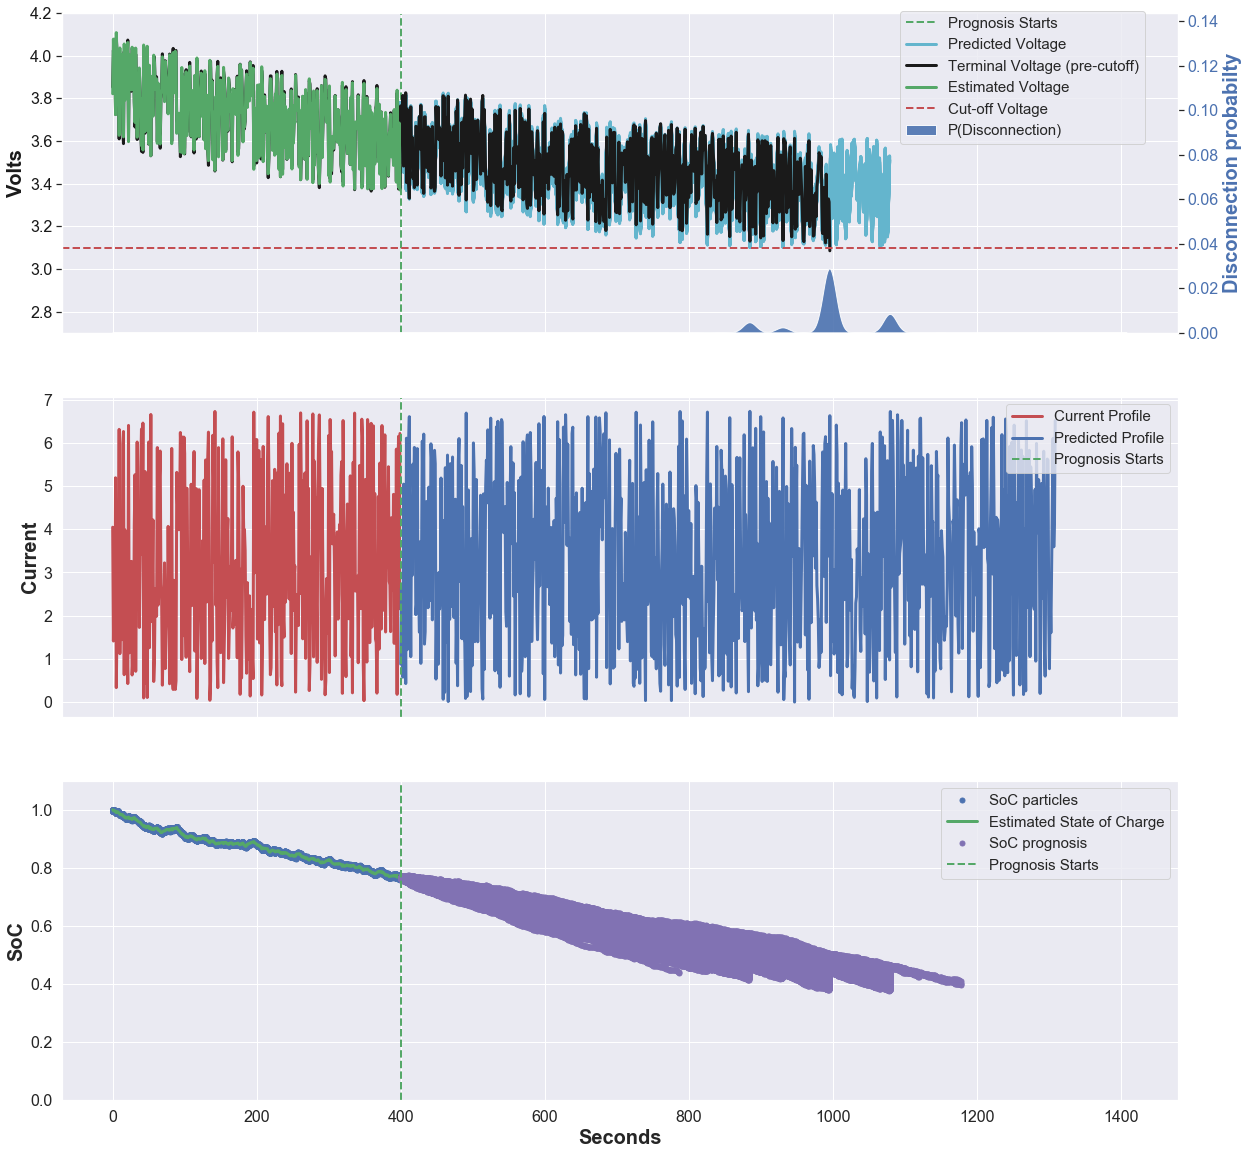

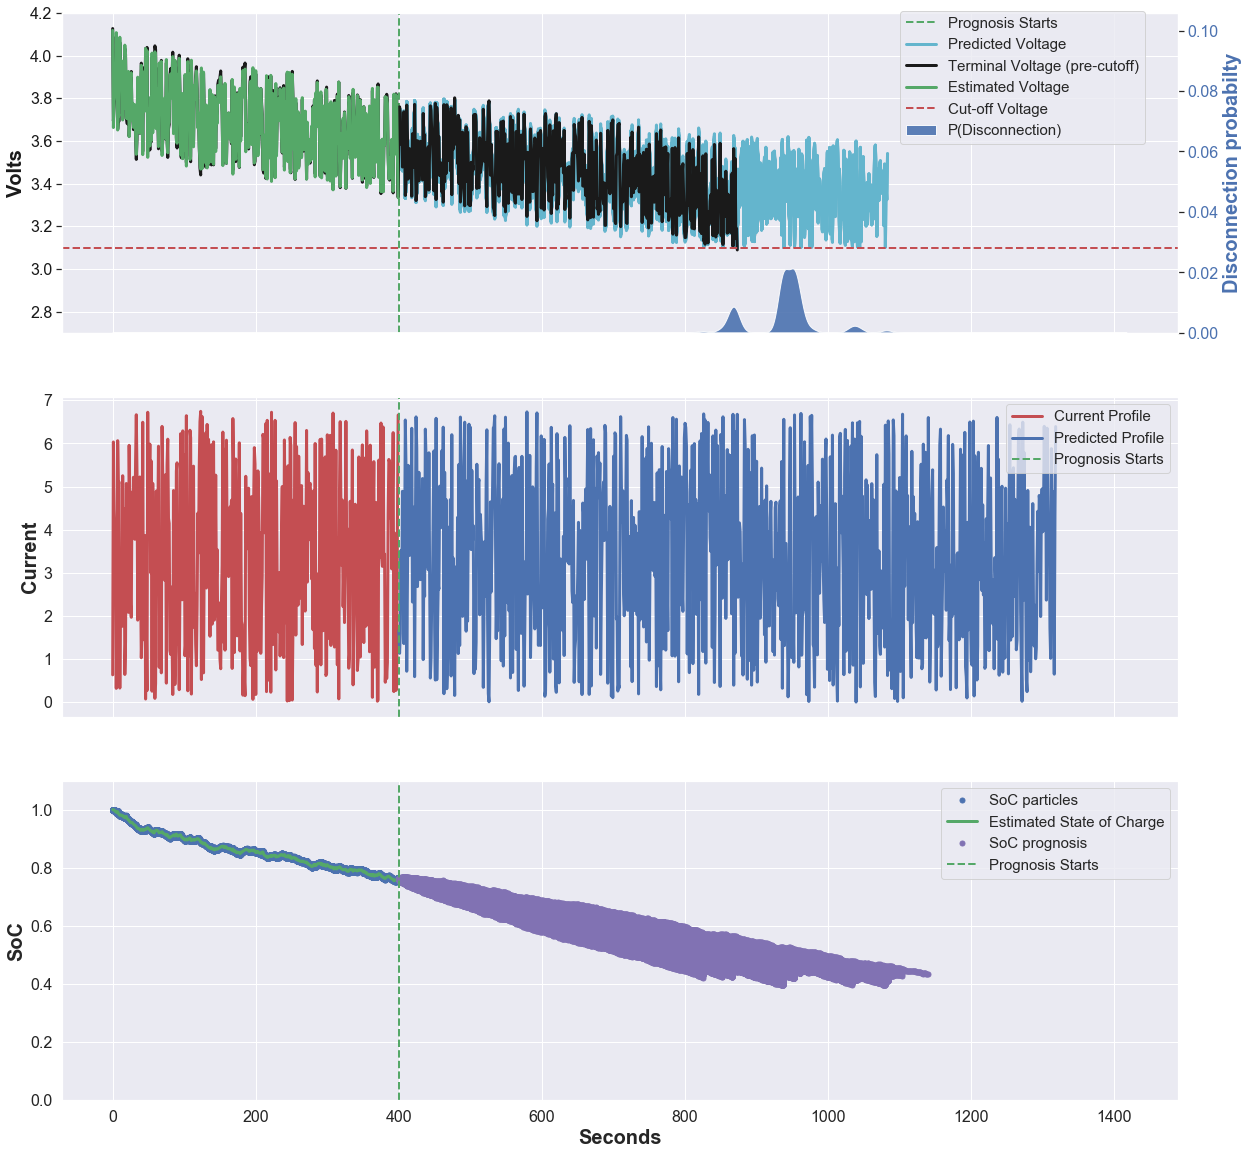

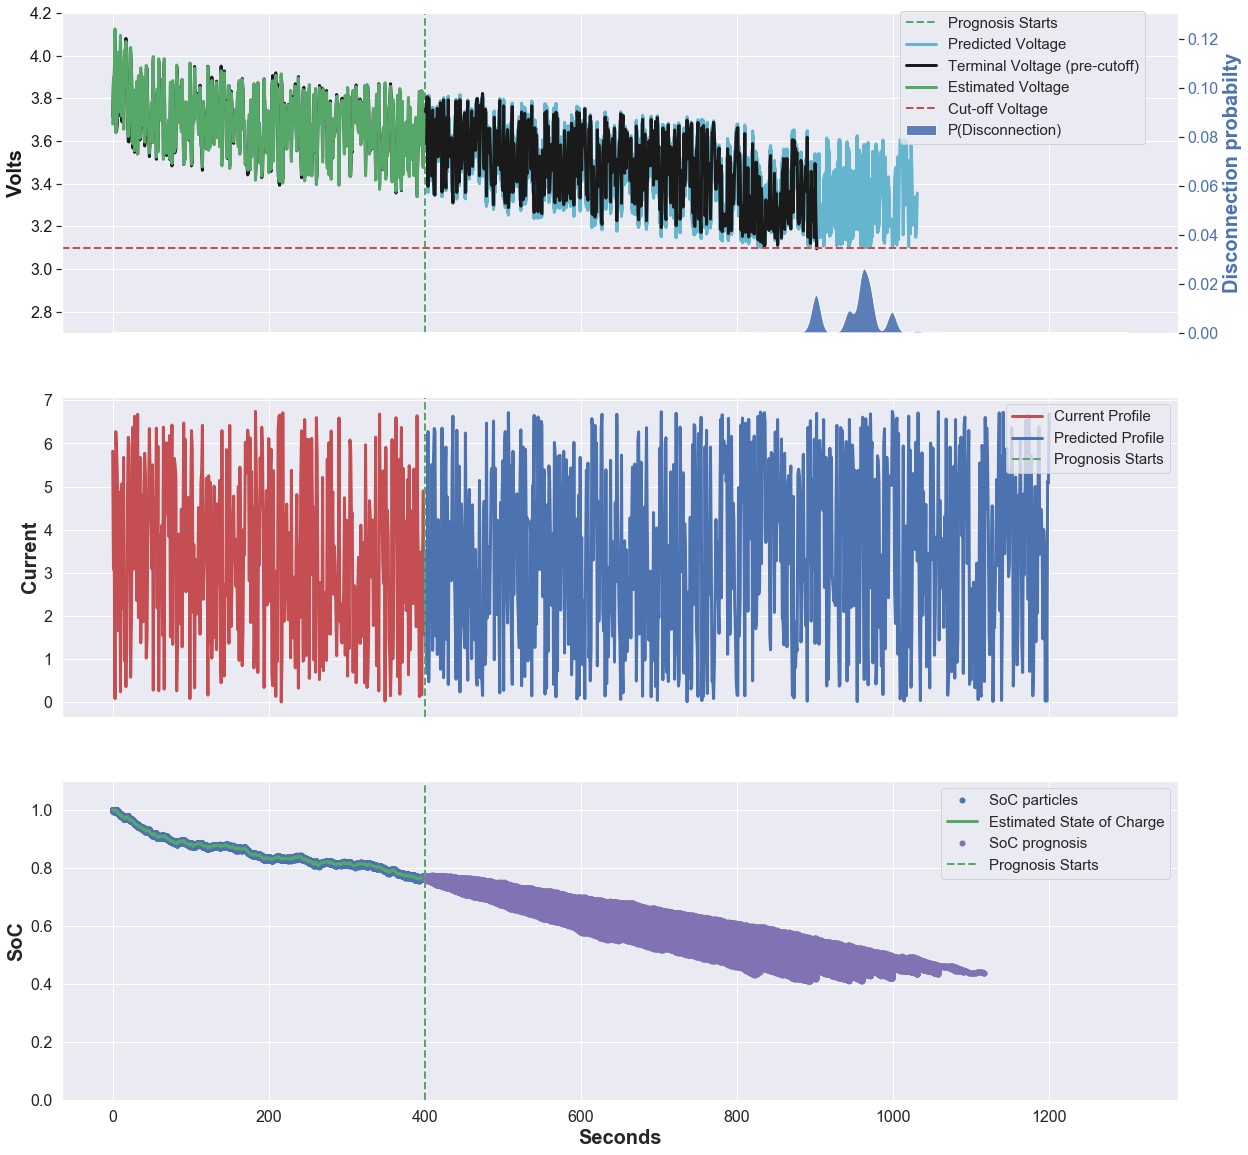

In [6]:
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
font = {"figure.titlesize": 20,
        "figure.titleweight": 'normal',
        "axes.titlesize" : 20,
        "axes.labelsize" : 20,
        "lines.linewidth" : 3,
        "lines.markersize" : 10,
        "xtick.labelsize" : 16,
        "ytick.labelsize" : 16,
        'axes.labelweight': 'bold',
        'legend.fontsize': 15.0,
        'legend.loc': 'upper right'
       }
for key in font:
    matplotlib.rcParams[key] = font[key]

mc_samples = 10000
with torch.no_grad():
    vsmc.load_state_dict(nn_state)
    vsmc.to(device)
    title = ["Test Discharge (not used in training)", 
             "Random Discharge 1", "Random Discharge 2", "Random Discharge 3"]
    for j, set_dict in enumerate(Training_Set):
        if j != 0:
            state = torch.ones(N, 1) * 1.0
            loss, voltage, soc_hist, voltage_prediction, soc_prediction, SoMPA, pass_threshold = vsmc.SoMPA(state,
                                                               set_dict['Current'],
                                                               set_dict['Voltage'],
                                                               estimation_stop,
                                                               cut_off_voltage,
                                                                mc_samples=mc_samples)
            seconds = torch.ones_like(vsmc.voltage_expected_hist).numpy()
            voltage_expected_hist = vsmc.voltage_expected_hist.numpy()
            soc_expected_hist = vsmc.soc_expected_hist.numpy()
            current = np.array(set_dict['Current'])
            voltage_prediction = voltage_prediction.numpy()

            fig, (ax1, ax3, ax4) = plt.subplots(nrows=3, sharex=True)

            ax4.set_xlabel("Seconds")
#             ax4.set_xlim([0, 1200])
            ax1.axvline(x=estimation_stop, color='g', linestyle='--', label="Prognosis Starts", linewidth=2.0)
            color = 'k'
            ax1.set_ylabel("Volts", color=color)
            test = set_dict['Voltage'].T < cut_off_voltage
            gt_cuttoff = np.argmax(test, axis=0) + 1
            data_set = {
                "Model_Details": f"Degraded Battery discharge with NASSM, with known future discharge profile, set {j}",
                "MC_samples": mc_samples,
                "terminal_voltage": set_dict['Voltage'].T,
                "measured_current": set_dict['Current'][0, :estimation_stop].T,
                "current_prediction": set_dict['Current'][0, estimation_stop:].T,
                "estimation_stop": estimation_stop,
                "gt_cutoff_at": gt_cuttoff[0, 0],
                "cut_off_voltage": cut_off_voltage,
                "state_init": np.ones((N, 1)),
                "P(disconnection)": SoMPA,
                "voltage_estimate_particles": voltage,
                "voltage_expectation": voltage_expected_hist.T,
                "voltage_prediction": voltage_prediction,
                "SoC_estimate_particles": soc_hist.numpy().T,
                "SoC_expectation": soc_expected_hist.T,
                "SoC_prediction": soc_prediction.numpy(),
                "first_instance_beyond_threshold": pass_threshold,
            }
            
            downsample = np.random.randint(mc_samples, size=100)
            for j in range(downsample.shape[0]):
                i = downsample[j]
                ax1.plot(np.arange(estimation_stop, pass_threshold[i, 0]),
                         voltage_prediction[i, :(pass_threshold[i, 0]-estimation_stop)], '-c')
            ax1.plot([], '-c', label="Predicted Voltage")
            ax1.plot(set_dict['Voltage'].T[:gt_cuttoff[0,0]], linestyle='-', color=color, 
                     label="Terminal Voltage (pre-cutoff)")
            ax1.plot(voltage_expected_hist.T, '-g', label="Estimated Voltage")
            ax1.axhline(y=cut_off_voltage, color='r', linestyle='--', label="Cut-off Voltage", linewidth=2.0)
            ax1.tick_params(axis='y', labelcolor=color)
            ax1.set_ylim([2.7, 4.2])



            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            color = 'b'
            ax2.set_ylabel('Disconnection probabilty', color=color)  # we already handled the x-label with ax1
            ax2.fill(np.arange(0, SoMPA.shape[0]), SoMPA, fc=color, alpha=0.9, label='P(Disconnection)')
            ax2.tick_params(axis='y', labelcolor=color)
            ax2.set_ylim([0, SoMPA.max()*5.0])
            ax2.grid(None)
            fig.legend(bbox_to_anchor=(0.8, 0.80))

            ax3.plot(np.arange(0, estimation_stop), set_dict['Current'].T[:estimation_stop], '-r', label="Current Profile")
            ax3.plot(np.arange(estimation_stop, set_dict['Current'].shape[1]), set_dict['Current'].T[estimation_stop:], 
                     '-b', label="Predicted Profile")
            ax3.axvline(x=estimation_stop, color='g', linestyle='--', label="Prognosis Starts", linewidth=2.0)
            ax3.set_ylabel("Current")
            ax3.legend()

            ax4.plot(soc_hist.numpy().T, '.b')
            ax4.plot([],'.b', label="SoC particles")
            ax4.plot(soc_expected_hist.T,'-g', label="Estimated State of Charge")
            soc_pred = soc_prediction.numpy().T
            for i in range(pass_threshold.shape[0]):
                ax4.plot(np.arange(estimation_stop, pass_threshold[i, 0]), 
                         soc_pred[:(pass_threshold[i, 0]-estimation_stop), i], 
                         '.m')
            ax4.plot([], '.m', label="SoC prognosis")
            ax4.axvline(x=estimation_stop, color='g', linestyle='--', label="Prognosis Starts", linewidth=2.0)
            ax4.legend()
            ax4.set_ylabel("SoC")
            ax4.set_ylim([0.0, 1.1])

            plt.show()

In [29]:
class RNNetwork(nn.Module):
    def __init__(self):
        super(RNNetwork, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
        # SMC params
        self.E_crit = torch.Tensor([1.075])
        self.f_mean = torch.Tensor([0.0])
        self.f_std = torch.Tensor([0.00075])
        self.g_std = 0.005
        self.nu = torch.Tensor([1.0 / (self.g_std * np.sqrt(2 * np.pi))])
        self.voltage_expected_hist = None
        self.soc_expected_hist = None

    def VoC(self, SoC):
        v_L = torch.Tensor([[-1.59614486]]).to(device)
        v_0 = torch.Tensor([[4.13646328]]).to(device)
        gamma = torch.Tensor([[0.63726463]]).to(device)
        alpha = torch.Tensor([[1.40174122]]).to(device)
        beta = torch.Tensor([[2.54478965]]).to(device)
        return v_L + (v_0 - v_L) * torch.exp(gamma * (SoC - 1)) + alpha * v_L * (SoC - 1) \
               + (1 - alpha) * v_L * (torch.exp(-beta) - torch.exp(-beta * torch.sqrt(SoC)))

    def forward(self, soc_init, current, voltage_measured,  estimation_stop=None):
        first = True
        set_size = current.shape[1]
        if estimation_stop is not None and estimation_stop <= set_size:
            set_size = estimation_stop
        voltage = torch.empty((soc_init.shape[0], set_size), dtype=torch.float)
        soc_hist = torch.empty((soc_init.shape[0], set_size), dtype=torch.float)
        self.w_hist = torch.empty((soc_init.shape[0], set_size), dtype=torch.float)
        self.voltage_expected_hist = torch.empty((1, set_size), dtype=torch.float)
        self.soc_expected_hist = torch.empty((1, set_size), dtype=torch.float)
        self.E_crit = self.E_crit.to(device, torch.float)
        soc = soc_init.to(device, torch.float)
        N = soc_init.shape[0]

        I = torch.ones(N, 1) * current[0, 0]
        I = I.to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        scaled_soc = apply_scale(soc, SoC_min, SoC_max)
        # Estimate Z_p
        combined = torch.cat((scaled_soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)

        # Estimate prior V
        V = self.VoC(soc) - I * Z
        for t in range(set_size):

            # Predict SoC
            soc = soc - I*V/Characterisation_Set['E_crit']*self.E_crit
            # Add model uncertainty
            soc = soc + torch.normal(torch.ones([N, 1]) * self.f_mean, torch.ones([N, 1]) * self.f_std).to(device)

            # Bounds
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001

            # Posterior Evidence
            I = torch.ones(N, 1) * current[0, t]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Estimate posterior V
            V = self.VoC(soc) - I*Z

            #SMC
            W = self.nu * torch.exp(-0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0))
            logW = torch.log(self.nu) - 0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0)

            max_logW = logW.max()
            loss_W = torch.exp(logW - max_logW)

            if not first:
                loss = loss + max_logW + torch.log(torch.sum(loss_W)) - torch.Tensor([np.log(N)])
            else:
                loss = max_logW + torch.log(torch.sum(loss_W)) - torch.Tensor([np.log(N)])
                first = False

            # Resampling
            soc, W = resample(soc, loss_W)

            self.w_hist[:, t] = W[:, 0]
            voltage[:, t] = V[:, 0]
            soc_hist[:, t] = soc[:, 0]
            self.voltage_expected_hist[0, t] = V.transpose(0, 1).mm(W.to(device))
            self.soc_expected_hist[0, t] = soc.transpose(0, 1).mm(W.to(device))

            self.last_soc = soc.transpose(0, 1).mm(W.to(device))

        return loss, voltage, soc_hist
    
    def SoMPA(self, soc_init, current, voltage_measured, estimation_stop, cut_off_voltage, mc_samples=10000, extend_pred_by=None):
        loss, voltage, soc_hist = self.forward(soc_init, current, voltage_measured, estimation_stop=estimation_stop)    
        set_size = current.shape[1] - soc_hist.shape[1]
        if extend_pred_by is not None:
            set_size += extend_pred_by
        N = mc_samples
        soc = torch.ones((N, 1), dtype=torch.float).to(device)*self.last_soc
        voltage_prediction = torch.empty((soc.shape[0], set_size), dtype=torch.float)
        soc_prediction = torch.empty((soc.shape[0], set_size), dtype=torch.float)

        I = torch.ones(N, 1) * current[0, estimation_stop-1]
        I = I.to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        scaled_soc = apply_scale(soc, SoC_min, SoC_max)
        # Estimate Z_p
        combined = torch.cat((scaled_soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)

        # Estimate prior V
        V = self.VoC(soc) - I * Z
        for t in range(0, set_size):
            i = soc_hist.shape[1] + t
            # Predict SoC
            soc = soc - I*V/Characterisation_Set['E_crit']*self.E_crit
            # Add model uncertainty
            soc = soc + torch.normal(torch.ones([N, 1]) * self.f_mean, torch.ones([N, 1]) * self.f_std).to(device)

            # Bounds
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001

            # Posterior Evidence
            if i > (current.shape[1] - 1):
                a = current.min()
                b = current.max()
                current_rand = (b - a) * np.random.random_sample() + a
                I = torch.ones(N, 1) * current_rand
                I = I.to(device, torch.float)
            else:
                I = torch.ones(N, 1) * current[0, i]
                I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Estimate posterior V
            V = self.VoC(soc) - I * Z
            voltage_prediction[:, t] = V[:, 0]
            soc_prediction[:, t] = soc[:, 0]
            SoMPA_pdf = None
        # Generate SoMPA KDE
        from sklearn.neighbors import KernelDensity
        test_V = voltage_prediction.numpy().T <= cut_off_voltage
        first_past_threshold = np.argmax(test_V, axis=0)[:, np.newaxis]
        min_test = first_past_threshold[:, 0] == 0.0
        first_past_threshold[min_test, 0] = first_past_threshold.max()
        first_past_threshold += estimation_stop
        std_samples = np.std(first_past_threshold)
        SoMPA_base = np.arange(0, current.shape[1]+100+extend_pred_by)[:, np.newaxis]
        log_dens = KernelDensity(kernel='gaussian', bandwidth=1.06*std_samples*np.power(mc_samples, -1/5.0)).fit(first_past_threshold).score_samples(SoMPA_base)
        SoMPA_pdf = np.exp(log_dens)

        return loss, voltage, soc_hist, voltage_prediction, soc_prediction, SoMPA_pdf, first_past_threshold
        
        
        
        

In [30]:
vsmc = RNNetwork()
saved_network = "./Battery_Data/new_battery_cycles/Battery_RNN_from_prior_v4"
parts = 10
N = 100
estimation_stop, cut_off_voltage = 400, 3.1
saved = "{0}_part_{1}.mdl".format(saved_network, parts)
nn_state = torch.load(saved)

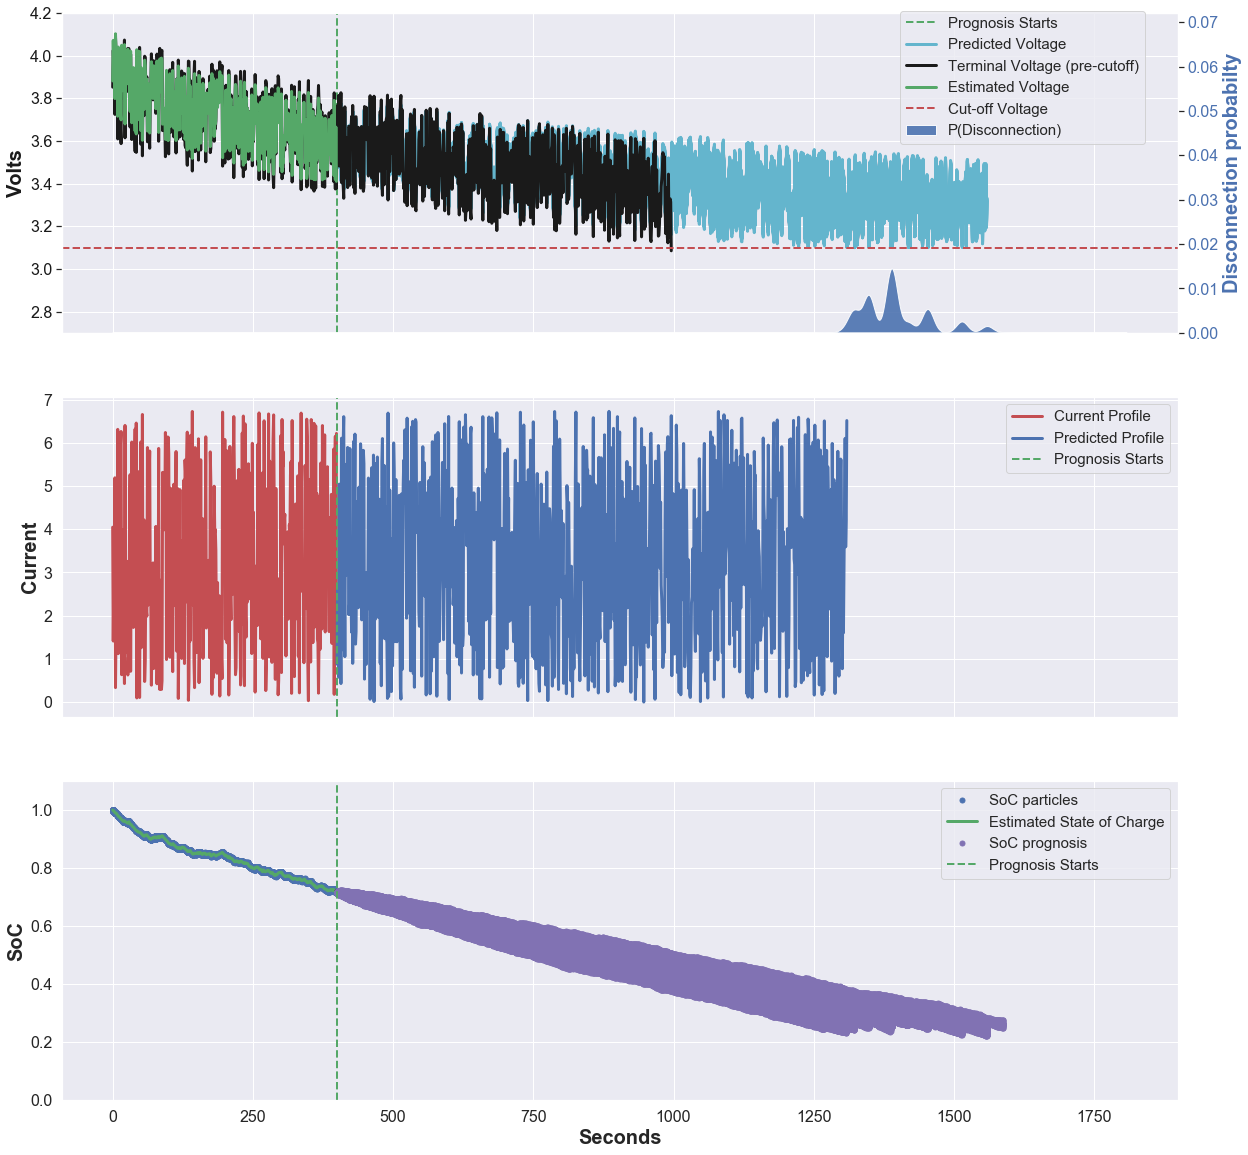

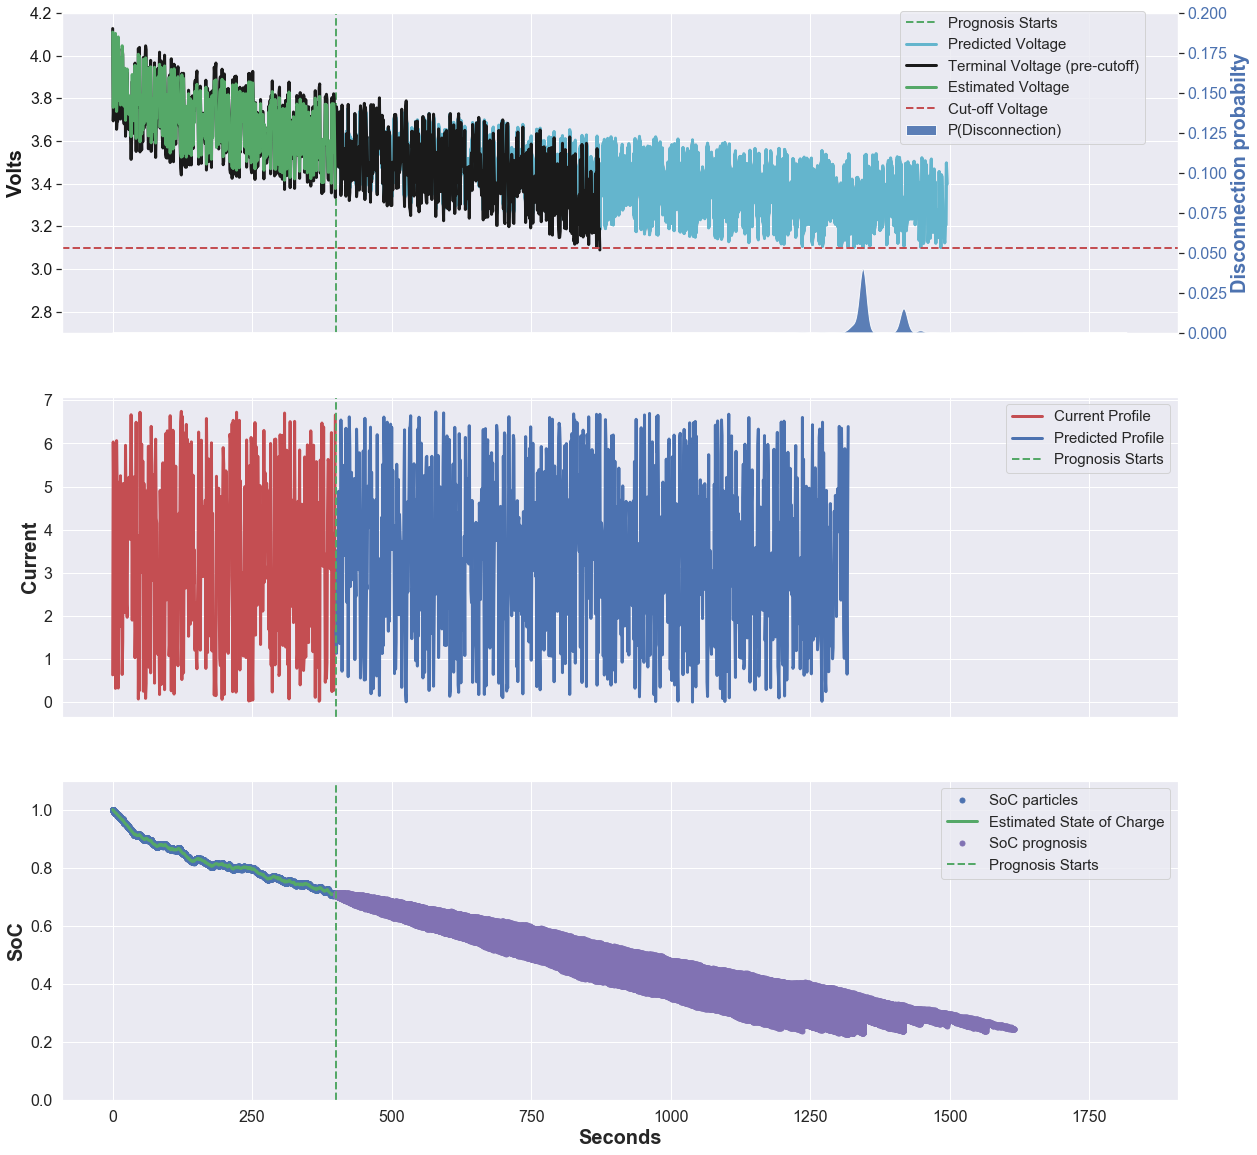

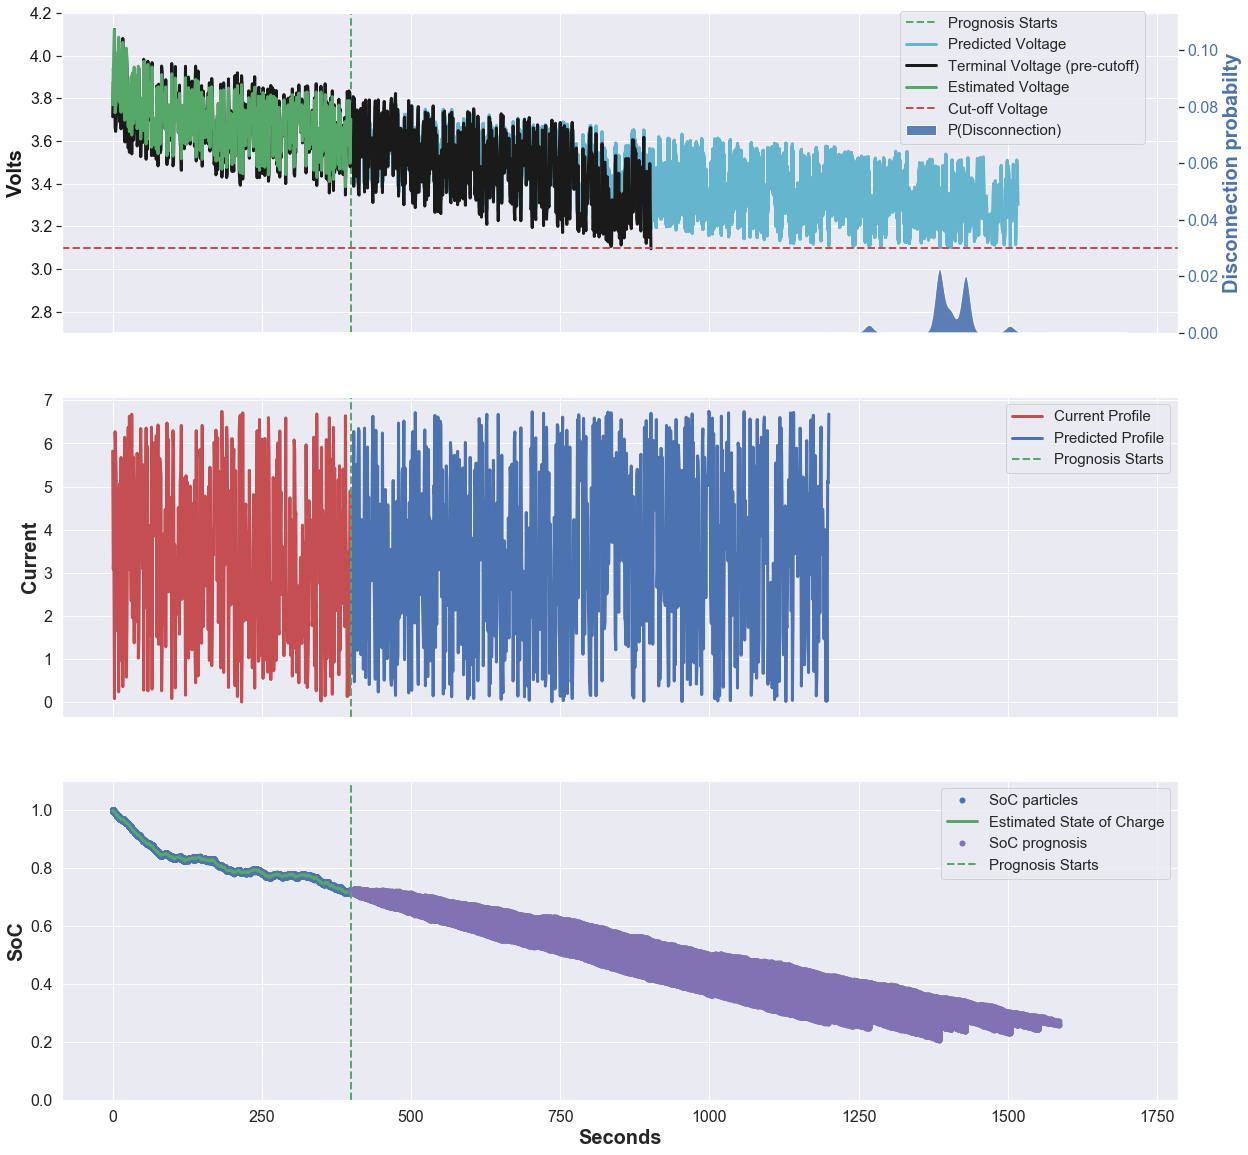

In [35]:
results_saved_to = "/home/chris/Dropbox/University/Publications/NASSM/IEEE Access/Simulation_Results"
mc_samples = 10000
with torch.no_grad():
    vsmc.load_state_dict(nn_state)
    vsmc.to(device)
    title = ["Test Discharge (not used in training)", 
             "Random Discharge 1", "Random Discharge 2", "Random Discharge 3"]
    for j, set_dict in enumerate(Training_Set):
        if j != 0:
            state = torch.ones(N, 1) * 1.0
            loss, voltage, soc_hist, voltage_prediction, soc_prediction, SoMPA, pass_threshold = vsmc.SoMPA(state,
                                                               set_dict['Current'],
                                                               set_dict['Voltage'],
                                                               estimation_stop,
                                                               cut_off_voltage,
                                                                mc_samples=mc_samples, extend_pred_by=400)
            seconds = torch.ones_like(vsmc.voltage_expected_hist).numpy()
            voltage_expected_hist = vsmc.voltage_expected_hist.numpy()
            soc_expected_hist = vsmc.soc_expected_hist.numpy()
            current = np.array(set_dict['Current'])
            voltage_prediction = voltage_prediction.numpy()
            test = set_dict['Voltage'].T < cut_off_voltage
            gt_cuttoff = np.argmax(test, axis=0) + 1
            data_set = {
                "Model_Details": f"New Battery discharge on degraded data with NASSM, with known future discharge profile, set {j}",
                "MC_samples": mc_samples,
                "terminal_voltage": set_dict['Voltage'].T,
                "measured_current": set_dict['Current'][0, :estimation_stop].T,
                "current_prediction": set_dict['Current'][0, estimation_stop:].T,
                "estimation_stop": estimation_stop,
                "gt_cutoff_at": gt_cuttoff[0, 0],
                "cut_off_voltage": cut_off_voltage,
                "state_init": np.ones((N, 1)),
                "P(disconnection)": SoMPA,
                "voltage_estimate_particles": voltage,
                "voltage_expectation": voltage_expected_hist.T,
                "voltage_prediction": voltage_prediction,
                "SoC_estimate_particles": soc_hist.numpy().T,
                "SoC_expectation": soc_expected_hist.T,
                "SoC_prediction": soc_prediction.numpy(),
                "first_instance_beyond_threshold": pass_threshold,
            }
            with open(f"{results_saved_to}/new_NASSM_degraded_set_{j}.p", 'wb') as f:
                pickle.dump(data_set, f, pickle.HIGHEST_PROTOCOL)
            fig, (ax1, ax3, ax4) = plt.subplots(nrows=3, sharex=True)

            ax4.set_xlabel("Seconds")
    #             ax4.set_xlim([0, 1200])
            ax1.axvline(x=estimation_stop, color='g', linestyle='--', label="Prognosis Starts", linewidth=2.0)
            color = 'k'
            ax1.set_ylabel("Volts", color=color)

            downsample = np.random.randint(mc_samples, size=100)
            for j in range(downsample.shape[0]):
                i = downsample[j]
                ax1.plot(np.arange(estimation_stop, pass_threshold[i, 0]),
                         voltage_prediction[i, :(pass_threshold[i, 0]-estimation_stop)], '-c')
            ax1.plot([], '-c', label="Predicted Voltage")
            ax1.plot(set_dict['Voltage'].T[:gt_cuttoff[0,0]], linestyle='-', color=color, 
                     label="Terminal Voltage (pre-cutoff)")
            ax1.plot(voltage_expected_hist.T, '-g', label="Estimated Voltage")
            ax1.axhline(y=cut_off_voltage, color='r', linestyle='--', label="Cut-off Voltage", linewidth=2.0)
            ax1.tick_params(axis='y', labelcolor=color)
            ax1.set_ylim([2.7, 4.2])



            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            color = 'b'
            ax2.set_ylabel('Disconnection probabilty', color=color)  # we already handled the x-label with ax1
            ax2.fill(np.arange(0, SoMPA.shape[0]), SoMPA, fc=color, alpha=0.9, label='P(Disconnection)')
            ax2.tick_params(axis='y', labelcolor=color)
            ax2.set_ylim([0, SoMPA.max()*5.0])
            ax2.grid(None)
            fig.legend(bbox_to_anchor=(0.8, 0.80))

            ax3.plot(np.arange(0, estimation_stop), set_dict['Current'].T[:estimation_stop], '-r', label="Current Profile")
            ax3.plot(np.arange(estimation_stop, set_dict['Current'].shape[1]), set_dict['Current'].T[estimation_stop:], 
                     '-b', label="Predicted Profile")
            ax3.axvline(x=estimation_stop, color='g', linestyle='--', label="Prognosis Starts", linewidth=2.0)
            ax3.set_ylabel("Current")
            ax3.legend()

            ax4.plot(soc_hist.numpy().T, '.b')
            ax4.plot([],'.b', label="SoC particles")
            ax4.plot(soc_expected_hist.T,'-g', label="Estimated State of Charge")
            soc_pred = soc_prediction.numpy().T
            for i in range(pass_threshold.shape[0]):
                ax4.plot(np.arange(estimation_stop, pass_threshold[i, 0]), 
                         soc_pred[:(pass_threshold[i, 0]-estimation_stop), i], 
                         '.m')
            ax4.plot([], '.m', label="SoC prognosis")
            ax4.axvline(x=estimation_stop, color='g', linestyle='--', label="Prognosis Starts", linewidth=2.0)
            ax4.legend()
            ax4.set_ylabel("SoC")
            ax4.set_ylim([0.0, 1.1])

            plt.show()